In [1]:
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

In [2]:
import joblib

X_train, X_test, y_train, y_test = joblib.load("artifacts/car_data_selected.joblib")

In [3]:
print(X_train.shape, X_test.shape)

(1232, 10) (309, 10)


In [4]:
# Load the price scaler
target_scaler = joblib.load('artifacts/price_yj_scaler.pkl')

def get_original_price(y_transformed):
    return target_scaler.inverse_transform(y_transformed.values.reshape(-1, 1)).flatten()

y_test_original = get_original_price(y_test)

In [5]:
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
from sklearn.base import RegressorMixin

def get_metrics(model: RegressorMixin):
    y_pred = model.predict(X_test)
    y_pred = get_original_price(pd.Series(y_pred))

    return {
        "MSE": mean_squared_error(y_test_original, y_pred),
        "RMSE": root_mean_squared_error(y_test_original, y_pred),
        "MAE": mean_absolute_error(y_test_original, y_pred),
        "R2": r2_score(y_test_original, y_pred)
    }

# SVR

In [7]:
from sklearn.svm import SVR

svr_model = SVR(C=100, gamma=0.1, epsilon=.1)
svr_model.fit(X_train, y_train)

SVR(C=100, gamma=0.1)

In [8]:
get_metrics(svr_model)

{'MSE': 173318261990.7978,
 'RMSE': 416315.0994028415,
 'MAE': 191180.20522788266,
 'R2': 0.8620147311107015}

# Random Forest

In [9]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [10]:
get_metrics(rf_model)

{'MSE': 100916131999.37651,
 'RMSE': 317672.9953889322,
 'MAE': 174072.36547365668,
 'R2': 0.9196568241035025}

# Hyperparameter Tuning

## SVR

In [11]:
from sklearn.model_selection import GridSearchCV

# Define the base model
svr = SVR(kernel='rbf')

# Define the parameter grid
param_grid = {
    'C': [10, 50, 100, 200, 500],
    'gamma': [0.01, 0.05, 0.1, 0.5, 1],
    'epsilon': [0.01, 0.05, 0.1, 0.2]
}

# Setup GridSearchCV
svr_grid = GridSearchCV(
    estimator=svr,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=-1,
    verbose=2
)

# Fit the model on training data
svr_grid.fit(X_train, y_train)

# Display best parameters and performance
print("Best Parameters:", svr_grid.best_params_)
best_svr = svr_grid.best_estimator_

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters: {'C': 100, 'epsilon': 0.1, 'gamma': 0.05}


In [12]:
get_metrics(svr_grid)

{'MSE': 153964965146.97446,
 'RMSE': 392383.6963317595,
 'MAE': 187031.12234386662,
 'R2': 0.8774226277640337}

## Random Forest

In [13]:
# Define the base model
rf = RandomForestRegressor(random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Setup GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=-1,
    verbose=2
)

# Fit the model on the training data
grid_search.fit(X_train, y_train)

# Display best parameters and performance
print("Best Parameters:", grid_search.best_params_)
best_rf = grid_search.best_estimator_

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [14]:
get_metrics(best_rf)

{'MSE': 133053224721.28041,
 'RMSE': 364764.61550057237,
 'MAE': 187548.06005418356,
 'R2': 0.8940712607034513}

# Model Evaluation

In [15]:
models = {
    "SVR": svr_model,
    "Random Forest": rf_model,
    "SVR (Grid Search)": best_svr,
    "Random Forest (Grid Search)": best_rf
}

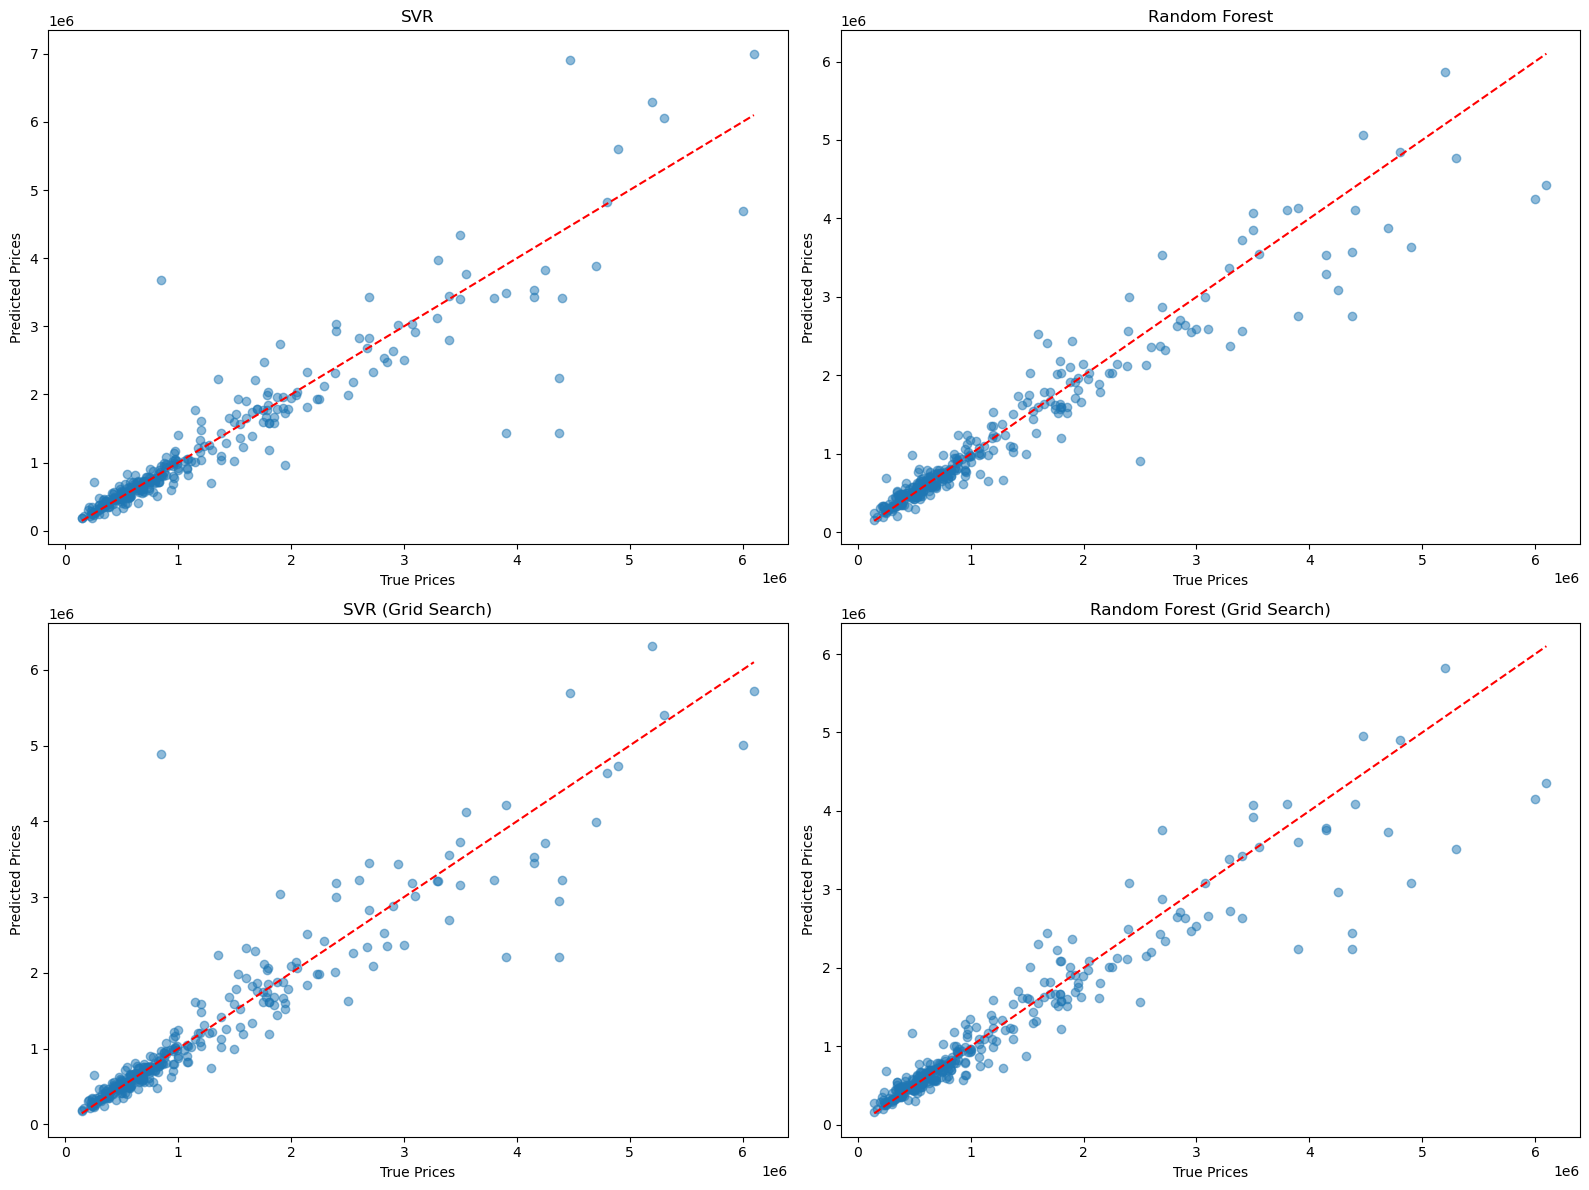

In [16]:
plt.figure(figsize=(16, 12))

for i, (name, model) in enumerate(models.items(), 1):
    y_pred = model.predict(X_test)
    y_pred = get_original_price(pd.Series(y_pred))
    y_true = y_test_original
    
    plt.subplot(2, 2, i)
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel("True Prices")
    plt.ylabel("Predicted Prices")
    plt.title(name)
    plt.tight_layout()
plt.show()

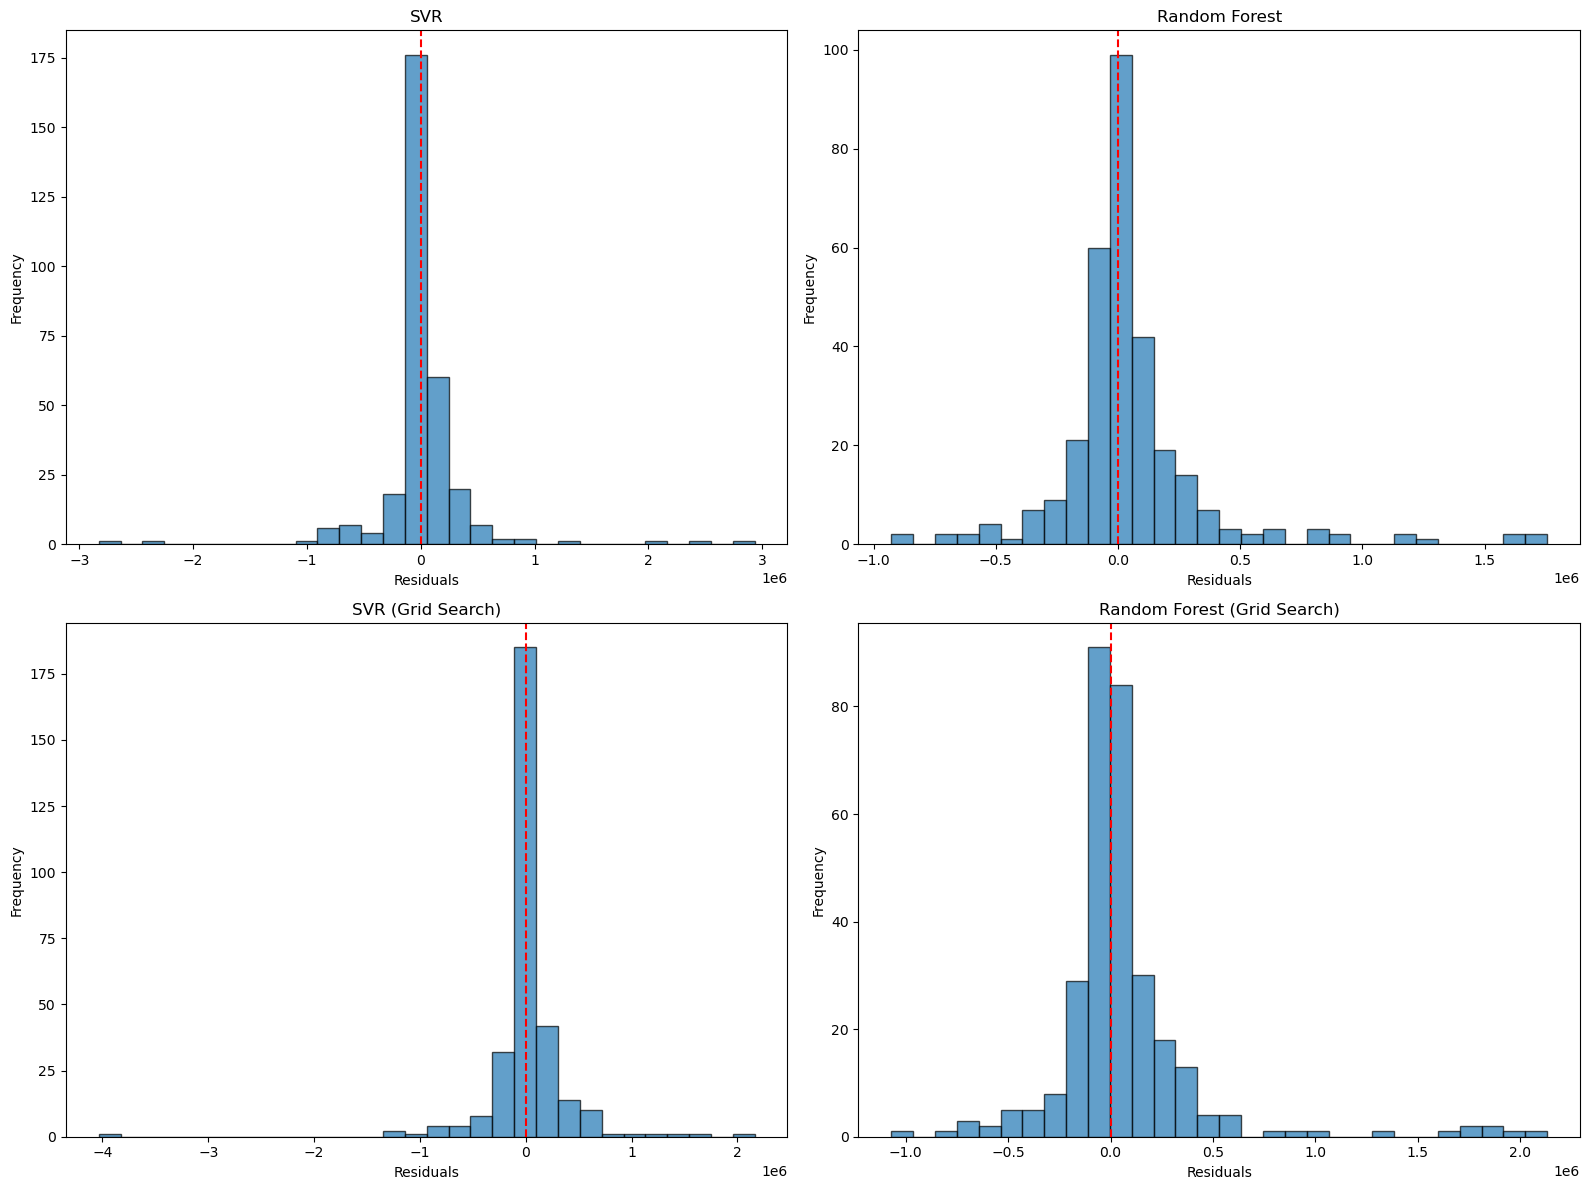

In [17]:
plt.figure(figsize=(16, 12))

for i, (name, model) in enumerate(models.items(), 1):
    y_pred = model.predict(X_test)
    y_pred = get_original_price(pd.Series(y_pred))
    y_true = y_test_original
    residuals = y_true - y_pred
    
    plt.subplot(2, 2, i)
    plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7)
    plt.axvline(0, color='r', linestyle='--', label='Zero Error')
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")
    plt.title(name)
    plt.tight_layout()
plt.show()